In [1]:
import sys
sys.path.append("../src")
from earthdata import utils

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import shapely as sh
from progressbar import progressbar as pbar
from importlib import reload
import os
reload(utils)


<module 'earthdata.utils' from '/home/rlx/earth-datasets/notebooks/../src/earthdata/utils.py'>

In [2]:
natural_earth_boundaries_file = "/opt/earthdata/world-tiles/natural_earth_countries.parquet"

tiles_folder = '/opt/earthdata/world-tiles/tiles-definitions'
tiles_file = '/opt/earthdata/world-tiles/tiles-definitions.parquet'

os.makedirs(tiles_folder, exist_ok=True)

In [4]:
z = gpd.read_parquet(natural_earth_boundaries_file)
print (z.shape)
z.head()

(258, 7)


geometry SOVEREIGNT SOV_A3  \
0  MULTIPOLYGON (((117.73807 4.15724, 117.78357 4...  Indonesia    IDN   
1  MULTIPOLYGON (((117.64405 4.21524, 117.64015 4...   Malaysia    MYS   
2  MULTIPOLYGON (((-69.49712 -17.62140, -69.47578...      Chile    CHL   
3  POLYGON ((-69.50834 -17.43403, -69.51139 -17.3...    Bolivia    BOL   
4  MULTIPOLYGON (((-69.68390 -17.65604, -69.72904...       Peru    PER   

       CONTINENT REGION_UN           SUBREGION                  REGION_WB  
0           Asia      Asia  South-Eastern Asia        East Asia & Pacific  
1           Asia      Asia  South-Eastern Asia        East Asia & Pacific  
2  South America  Americas       South America  Latin America & Caribbean  
3  South America  Americas       South America  Latin America & Caribbean  
4  South America  Americas       South America  Latin America & Caribbean

In [181]:
# extend the world sea boundary to cover better the coastlines
world = sh.ops.unary_union(z.geometry.values)
world_extended = world.buffer(0.02)

In [182]:
# create the grid
minlon, maxlon = -180, 180
minlat, maxlat = -90, 90
arcsize = 5
lonrange = np.arange(minlon, maxlon+arcsize, arcsize)
latrange = np.arange(minlat, maxlat+arcsize, arcsize)
grid = []
for loni in pbar(range(len(lonrange)-1)):
    for lati in range(len(latrange)-1):
        lat1,lat2 = latrange[lati], latrange[lati+1]
        lon1,lon2 = lonrange[loni], lonrange[loni+1]
        p = sh.geometry.Polygon([[lon1,lat1], [lon1, lat2], [lon2, lat2], [lon2, lat1]]).intersection(world_extended)
        if p.area>0:
            grid.append(p)

100% (72 of 72) |########################| Elapsed Time: 0:01:42 Time:  0:01:420108


In [227]:
# save the grid
grid_df = get_gdf(grid, crs=z.crs)
grid_df['tile_id'] = [utils.get_region_hash(gi) for gi in pbar(grid_df.geometry)]
grid_df.set_index('tile_id', inplace=True)
grid_df.to_parquet(tiles_file)

100% (1005 of 1005) |####################| Elapsed Time: 0:00:00 Time:  0:00:000:00


<Axes: >

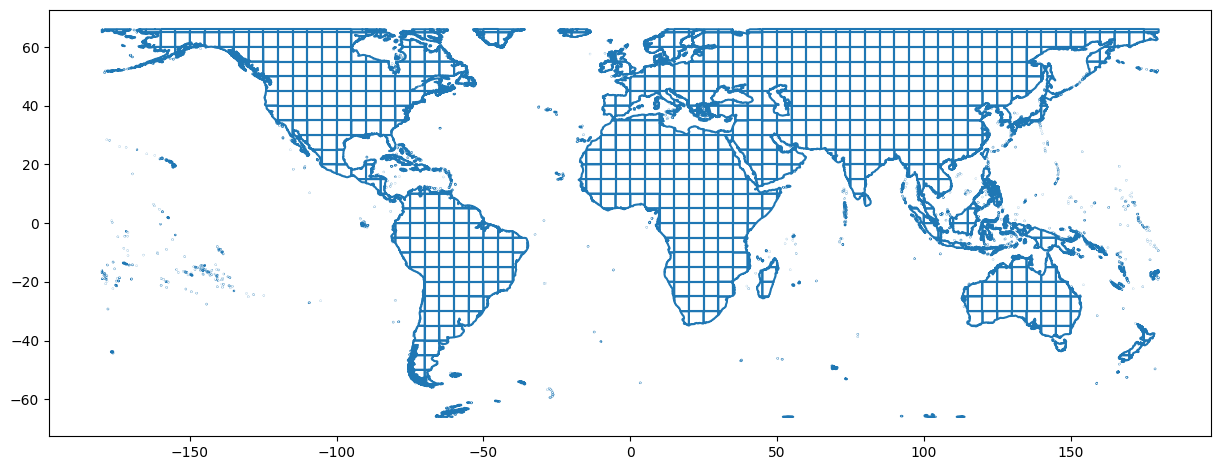

In [8]:
# just for plotting
gg = grid_df.copy()
gg['geometry'] = [gi.boundary for gi in gg.geometry.values]
gg.plot(figsize=(15,10))

In [243]:
# save wkt geometries for each tile so that it is prepared for geetiles
for _,row in pbar(grid_df.iterrows(), max_value=len(grid_df)):
    with open(f"{tiles_folder}/{row.name}.wkt", "w") as f:
        wkt_string = sh.wkt.dumps(row.geometry)
        f.write(wkt_string)
    

100% (1005 of 1005) |####################| Elapsed Time: 0:00:03 Time:  0:00:030000


In [11]:
from geetiles import cmds

grid_df = gpd.read_parquet(tiles_file)
grid_df

geometry
tile_id                                                         
135b822001123  MULTIPOLYGON (((-176.25110 -44.30865, -176.251...
155f57837a7fb  POLYGON ((-177.95819 -29.25608, -177.96029 -29...
01f60b872e94e  MULTIPOLYGON (((-175.00000 -21.40917, -175.000...
3114db1c4e8c8  MULTIPOLYGON (((-180.00000 -16.75288, -179.930...
01a9c039cd8c7  MULTIPOLYGON (((-176.19624 -13.35411, -176.197...
...                                                          ...
056b252fc1253  MULTIPOLYGON (((179.87889 -9.38288, 179.87692 ...
30f6b787c4b66  MULTIPOLYGON (((175.00000 -1.49738, 175.00268 ...
2650cf27e0a24  MULTIPOLYGON (((179.48228 51.94833, 179.47848 ...
188d68a2d14d1  POLYGON ((175.00000 65.00000, 177.08512 65.000...
15365ff6454c4  POLYGON ((175.00000 66.02000, 180.00000 66.020...

[1005 rows x 1 columns]

In [12]:
wkt_files = [f for f in os.listdir(tiles_folder) if f.endswith(".wkt")]
len(wkt_files)

1005

In [ ]:
# create the chips for every  tile
for wkt_file in wkt_files:
    aoi_wkt_file = f"{tiles_folder}/{wkt_file}"
    aoi_name = wkt_file.split(".")[0]
    chip_size_meters = 5120
    
    cfiles = [i for i in os.listdir(tiles_folder) if i.startswith(f"{aoi_name}_partitions")]
    if len(cfiles)>0:
        print (f"\n-----\n{wkt_file}s skipped")
        continue
    
    print (f"\n-----\n{wkt_file}\n-----")
    try:
        cmds.make_grid(aoi_wkt_file=aoi_wkt_file, 
                       chip_size_meters=chip_size_meters, 
                       aoi_name = aoi_name, 
                       dest_dir = tiles_folder)
    except Exception as e:
        print ("exception", e)
        

In [16]:
files = [f for f in os.listdir(tiles_folder) if f.endswith(".geojson")]
lens = []
for file in pbar(files):
    gz = gpd.read_file(f"{tiles_folder}/{file}")
    lens.append(len(gz))

100% (994 of 994) |######################| Elapsed Time: 0:13:18 Time:  0:13:180705


In [17]:
sum(lens)

4930692

In [18]:
sum(lens) * 5.12*5.12

129255132.36479999

In [10]:
aoi_name = wkt_file.split(".")[0]

In [6]:
zz = gpd.read_file("/opt/earthdata/world-tiles/tiles-definitions/00def1f72375f_partitions_aschips_1f338e3ae1172.geojson")
zz

area_km2     identifier  \
0     26.204155  26e2b180d0477   
1     26.204155  378cbbdae7ff1   
2     26.204155  100c33ac2efb1   
3     26.204155  373d2515bdba2   
4     26.204155  2f0c2d5911a4b   
...         ...            ...   
7327  26.327492  225f9426137d4   
7328  26.327899  1e279d06d8726   
7329  26.328308  0613cd5864149   
7330  26.328718  0b9a2b864a032   
7331  26.329129  2182ca479e644   

                                               geometry  
0     POLYGON ((-105.03571 49.97698, -105.03571 50.0...  
1     POLYGON ((-105.03575 50.02303, -105.03575 50.0...  
2     POLYGON ((-105.03578 50.06908, -105.03578 50.1...  
3     POLYGON ((-105.03582 50.11513, -105.03582 50.1...  
4     POLYGON ((-105.03585 50.16118, -105.03585 50.2...  
...                                                 ...  
7327  POLYGON ((-100.02423 51.43521, -100.02423 51.4...  
7328  POLYGON ((-100.01922 51.48107, -100.01922 51.5...  
7329  POLYGON ((-100.01420 51.52693, -100.01420 51.5...  
7330  POLYGON ((-100.00917 51.57279, -100.00917 51.6...  
7331  POLYGON ((-100.00412 51.61865, -100.00412 51.6...  

[7332 rows x 3 columns]

In [7]:
zz.explore()